<a href="https://colab.research.google.com/github/JumanaRahim/workshop/blob/master/lnd_res_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/LUNG_NODULE_DETECTION-20230303T162309Z-001 (1)/LUNG_NODULE_DET1/lung_detection/train',
                                                   target_size = (300,300),
                                                   class_mode = 'binary',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 2923 images belonging to 2 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/LUNG_NODULE_DETECTION-20230303T162309Z-001 (1)/LUNG_NODULE_DET1/lung_detection/test',
                                                  target_size = (300,300),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 634 images belonging to 2 classes.


(300, 300, 3)
(1, 300, 300, 3)


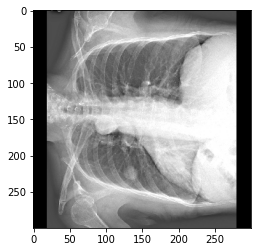

In [6]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image
img = image.load_img("/content/drive/MyDrive/LUNG_NODULE_DETECTION-20230303T162309Z-001 (1)/LUNG_NODULE_DET1/lung_detection/train/NODULE/n0001.png",target_size=(300,300))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [7]:
base_model = tf.keras.applications.ResNet50(input_shape=(300,300,3),include_top=False,weights="imagenet")

94765736/94765736 [==============================] - 1s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1,activation='sigmoid'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 dropout (Dropout)           (None, 10, 10, 2048)      0         
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 batch_normalization (BatchN  (None, 204800)           819200    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                6553632   
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

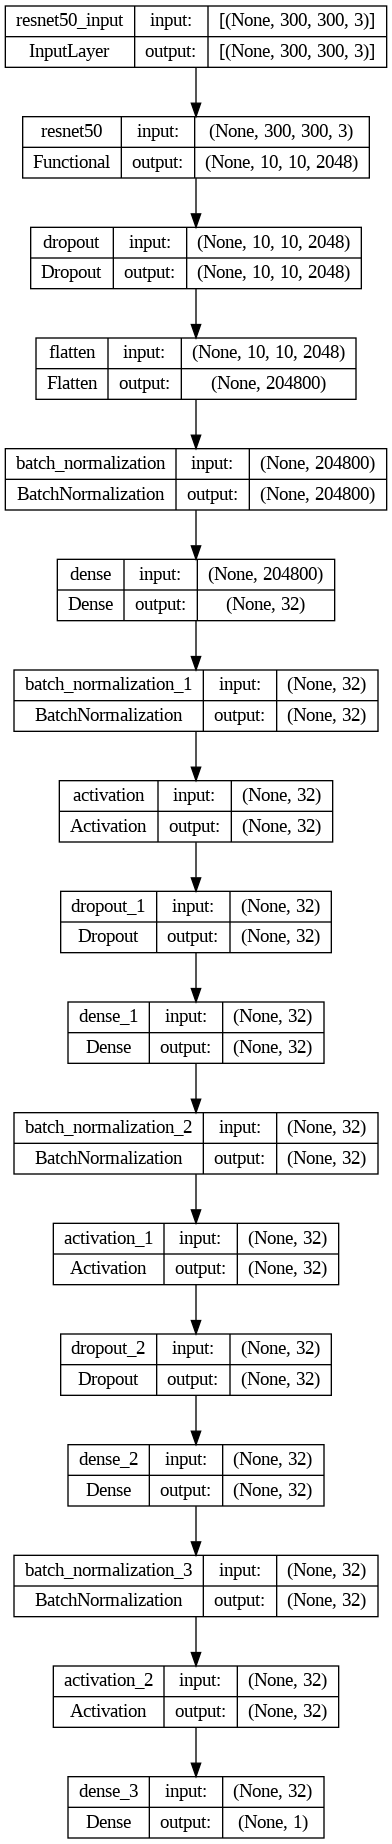

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [15]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,validation_data=test_dataset,epochs = 25,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/25
92/92 [==============================] - 1516s 16s/step - loss: 0.0000e+00 - accuracy: 0.3254 - precision: 0.7063 - recall: 0.0967 - auc: 0.5134 - f1_score: 0.1490 - val_loss: 0.0000e+00 - val_accuracy: 0.2114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4852 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/25
92/92 [==============================] - 1445s 16s/step - loss: 0.0000e+00 - accuracy: 0.2863 - precision: 1.0000 - recall: 0.0019 - auc: 0.5648 - f1_score: 0.0036 - val_loss: 0.0000e+00 - val_accuracy: 0.2114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4349 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/25
92/92 [==============================] - 1441s 16s/step - loss: 0.0000e+00 - accuracy: 0.2850 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5708 - f1_score: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.2114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4863 - val_f1_score: 0.0000e+00 - lr:

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)
​
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")
​
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
​
​
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])
​
​
    plt.show()
    
​
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )